# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "CF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'CF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups
Sample_004  P12277           16.116
Sample_121  P49641           18.445
Sample_126  Q16610           19.358
Sample_061  Q9Y6N6           15.045
Sample_045  Q5VWW1           15.881
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by CF: runs/alzheimer_study/preds/pred_real_na_CF.csv


Sample ID   protein groups        
Sample_027  P01743                   12.666
Sample_134  A0A0C4DH31               15.795
Sample_191  P80188;P80188-2;X6R8F3   15.444
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 13.529
            A0A075B6Q5                 12.500
            A0A075B6R2                 12.016
            A0A075B6S5                 12.876
            A0A087WSY4                 14.312
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.037
            Q9UI40;Q9UI40-2            12.237
            Q9UIW2                     12.214
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.336
            Q9UP79                     13.712
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.061,15.050,16.842,19.863,16.174,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.269,19.067,...,15.528,15.576,14.511,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.765,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.340,17.705,17.039,15.406,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.654,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.737,15.345,17.084,18.708,14.249,19.433,12.070,11.229
Sample_207,15.739,16.877,15.469,16.898,14.379,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,13.529,...,16.012,15.178,12.499,15.050,16.842,19.863,12.313,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.055,19.067,16.188,...,15.528,15.576,12.625,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,12.585,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,12.217,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.136,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,11.706,15.345,17.084,18.708,14.249,19.433,12.365,13.500
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 334.79it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.16it/s]

100%|██████████| 2/2 [00:00<00:00,  6.15it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.47it/s]

100%|██████████| 3/3 [00:00<00:00,  3.23it/s]

100%|██████████| 3/3 [00:00<00:00,  3.53it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.12it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  2.99it/s]

100%|██████████| 4/4 [00:01<00:00,  2.87it/s]

100%|██████████| 4/4 [00:01<00:00,  3.02it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.08it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.97it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.42it/s]

100%|██████████| 5/5 [00:01<00:00,  3.13it/s]

100%|██████████| 5/5 [00:01<00:00,  3.48it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.72it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.61it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.03it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.44it/s]

100%|██████████| 6/6 [00:01<00:00,  2.53it/s]

100%|██████████| 6/6 [00:01<00:00,  3.18it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.29it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.78it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.25it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.29it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.21it/s]

100%|██████████| 7/7 [00:02<00:00,  3.27it/s]

100%|██████████| 7/7 [00:02<00:00,  3.41it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.89it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.29it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.36it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.15it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.04it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.94it/s]

100%|██████████| 8/8 [00:02<00:00,  2.86it/s]

100%|██████████| 8/8 [00:02<00:00,  3.19it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.91it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.65it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.96it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.72it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.65it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.63it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.83it/s]

100%|██████████| 9/9 [00:03<00:00,  2.74it/s]

100%|██████████| 9/9 [00:03<00:00,  2.88it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  6.88it/s]

 30%|███       | 3/10 [00:00<00:01,  4.74it/s]

 40%|████      | 4/10 [00:00<00:01,  3.79it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.53it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.40it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.23it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.15it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.30it/s]

100%|██████████| 10/10 [00:02<00:00,  3.32it/s]

100%|██████████| 10/10 [00:02<00:00,  3.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  8.85it/s]

 27%|██▋       | 3/11 [00:00<00:01,  6.04it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.29it/s]

 45%|████▌     | 5/11 [00:01<00:01,  4.03it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.89it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.79it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  3.87it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.89it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.64it/s]

100%|██████████| 11/11 [00:02<00:00,  3.57it/s]

100%|██████████| 11/11 [00:02<00:00,  4.00it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  7.12it/s]

 25%|██▌       | 3/12 [00:00<00:01,  4.58it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.11it/s]

 42%|████▏     | 5/12 [00:01<00:01,  3.70it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.31it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.23it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.12it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.18it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.05it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  3.40it/s]

100%|██████████| 12/12 [00:03<00:00,  3.38it/s]

100%|██████████| 12/12 [00:03<00:00,  3.50it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  7.33it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.89it/s]

 31%|███       | 4/13 [00:00<00:02,  4.11it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.52it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.19it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.00it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.98it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.09it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.19it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  3.22it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.22it/s]

100%|██████████| 13/13 [00:03<00:00,  3.10it/s]

100%|██████████| 13/13 [00:03<00:00,  3.35it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  7.11it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.75it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.06it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.77it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.34it/s]

 50%|█████     | 7/14 [00:01<00:02,  3.03it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.98it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  2.93it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  2.97it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.05it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.12it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.19it/s]

100%|██████████| 14/14 [00:04<00:00,  3.19it/s]

100%|██████████| 14/14 [00:04<00:00,  3.32it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  7.17it/s]

 20%|██        | 3/15 [00:00<00:02,  4.99it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.20it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.97it/s]

 40%|████      | 6/15 [00:01<00:02,  3.43it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.45it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.38it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.55it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.60it/s]

 73%|███████▎  | 11/15 [00:02<00:01,  3.61it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.56it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.69it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  3.99it/s]

100%|██████████| 15/15 [00:03<00:00,  3.81it/s]

100%|██████████| 15/15 [00:03<00:00,  3.81it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.066 0.032          0.868 0.215       0.148   
2             0.006 0.004      0.079 0.036          0.784 0.087       0.708   
3             0.007 0.007      0.086 0.037          0.784 0.094       0.697   
4             0.004 0.003      0.052 0.020          0.783 0.103       0.736   
5             0.005 0.004      0.057 0.023          0.794 0.087       0.767   
6             0.007 0.006      0.072 0.025          0.809 0.073       0.798   
7             0.005 0.003      0.065 0.026          0.829 0.077       0.808   
8             0.006 0.005      0.070 0.027          0.838 0.078       0.820   
9             0.005 0.004      0.063 0.027          0.838 0.073       0.820   
10            0.004 0.001      0.048 0.011          0.827 0.078       0.811   
11            0.004 0.001      0.044 0.010          0.833 0.079       0.813   
12            0.004 0.000      0.047 0.007          0.834 0.075       0.806   
13            0.004 0.002      0.048 0.011          0.832 0.079       0.807   
14            0.004 0.001      0.041 0.015          0.826 0.082       0.796   
15            0.004 0.001      0.046 0.011          0.810 0.089       0.800   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.082   0.245 0.119                  0.566 0.041        0.854   
2          0.112   0.739 0.079                  0.781 0.061        0.867   
3          0.111   0.732 0.080                  0.776 0.062        0.866   
4          0.108   0.752 0.075                  0.790 0.061        0.877   
5          0.106   0.775 0.073                  0.808 0.061        0.886   
6          0.102   0.799 0.067                  0.829 0.056        0.920   
7          0.104   0.813 0.067                  0.842 0.055        0.917   
8          0.098   0.824 0.065                  0.850 0.054        0.916   
9          0.095   0.824 0.062                  0.851 0.052        0.917   
10         0.094   0.815 0.063                  0.842 0.053        0.916   
11         0.102   0.818 0.066                  0.846 0.056        0.914   
12         0.101   0.815 0.064                  0.843 0.053        0.913   
13         0.104   0.814 0.067                  0.842 0.056        0.914   
14         0.102   0.806 0.069                  0.835 0.057        0.912   
15         0.097   0.801 0.070                  0.829 0.059        0.915   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.065                  0.825 0.089        210.000 0.000  
2          0.059                  0.826 0.082        210.000 0.000  
3          0.057                  0.827 0.078        210.000 0.000  
4          0.060                  0.849 0.081        210.000 0.000  
5          0.053                  0.859 0.066        210.000 0.000  
6          0.046                  0.905 0.053        210.000 0.000  
7          0.047                  0.901 0.056        210.000 0.000  
8          0.048                  0.902 0.056        210.000 0.000  
9          0.048                  0.904 0.055        210.000 0.000  
10         0.048                  0.903 0.055        210.000 0.000  
11         0.048                  0.898 0.057        210.000 0.000  
12         0.048                  0.897 0.057        210.000 0.000  
13         0.048                  0.898 0.056        210.000 0.000  
14         0.049                  0.895 0.058        210.000 0.000  
15         0.049                  0.903 0.052 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 248.05it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.55it/s]

100%|██████████| 2/2 [00:00<00:00,  6.52it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.27it/s]

100%|██████████| 3/3 [00:00<00:00,  4.26it/s]

100%|██████████| 3/3 [00:00<00:00,  4.42it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.38it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  2.99it/s]

100%|██████████| 4/4 [00:01<00:00,  3.04it/s]

100%|██████████| 4/4 [00:01<00:00,  3.17it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.09it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.38it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.07it/s]

100%|██████████| 5/5 [00:01<00:00,  3.87it/s]

100%|██████████| 5/5 [00:01<00:00,  4.15it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  9.08it/s]

 50%|█████     | 3/6 [00:00<00:00,  6.57it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  5.78it/s]

 83%|████████▎ | 5/6 [00:00<00:00,  5.21it/s]

100%|██████████| 6/6 [00:01<00:00,  4.72it/s]

100%|██████████| 6/6 [00:01<00:00,  5.36it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  8.40it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.23it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.35it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.61it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.32it/s]

100%|██████████| 7/7 [00:01<00:00,  3.09it/s]

100%|██████████| 7/7 [00:01<00:00,  3.66it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.34it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.30it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.46it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.27it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.82it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.60it/s]

100%|██████████| 8/8 [00:02<00:00,  3.48it/s]

100%|██████████| 8/8 [00:02<00:00,  3.98it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  8.15it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.39it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.40it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.99it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.59it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.47it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.29it/s]

100%|██████████| 9/9 [00:02<00:00,  3.54it/s]

100%|██████████| 9/9 [00:02<00:00,  3.86it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 11.22it/s]

 40%|████      | 4/10 [00:00<00:00,  7.13it/s]

 50%|█████     | 5/10 [00:00<00:00,  6.60it/s]

 60%|██████    | 6/10 [00:00<00:00,  6.24it/s]

 70%|███████   | 7/10 [00:01<00:00,  6.06it/s]

 80%|████████  | 8/10 [00:01<00:00,  5.92it/s]

 90%|█████████ | 9/10 [00:01<00:00,  5.90it/s]

100%|██████████| 10/10 [00:01<00:00,  5.84it/s]

100%|██████████| 10/10 [00:01<00:00,  6.29it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 11.25it/s]

 36%|███▋      | 4/11 [00:00<00:00,  7.10it/s]

 45%|████▌     | 5/11 [00:00<00:00,  6.61it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  6.29it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  6.08it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  5.95it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  5.92it/s]

 91%|█████████ | 10/11 [00:01<00:00,  5.84it/s]

100%|██████████| 11/11 [00:01<00:00,  5.74it/s]

100%|██████████| 11/11 [00:01<00:00,  6.22it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 11.42it/s]

 33%|███▎      | 4/12 [00:00<00:01,  7.20it/s]

 42%|████▏     | 5/12 [00:00<00:01,  6.76it/s]

 50%|█████     | 6/12 [00:00<00:00,  6.45it/s]

 58%|█████▊    | 7/12 [00:01<00:00,  6.19it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  6.03it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  5.93it/s]

 83%|████████▎ | 10/12 [00:01<00:00,  5.82it/s]

 92%|█████████▏| 11/12 [00:01<00:00,  5.85it/s]

100%|██████████| 12/12 [00:01<00:00,  5.90it/s]

100%|██████████| 12/12 [00:01<00:00,  6.28it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:00, 11.37it/s]

 31%|███       | 4/13 [00:00<00:01,  7.15it/s]

 38%|███▊      | 5/13 [00:00<00:01,  6.60it/s]

 46%|████▌     | 6/13 [00:00<00:01,  6.27it/s]

 54%|█████▍    | 7/13 [00:01<00:00,  6.05it/s]

 62%|██████▏   | 8/13 [00:01<00:00,  6.00it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  5.89it/s]

 77%|███████▋  | 10/13 [00:01<00:00,  5.89it/s]

 85%|████████▍ | 11/13 [00:01<00:00,  5.83it/s]

 92%|█████████▏| 12/13 [00:01<00:00,  5.78it/s]

100%|██████████| 13/13 [00:02<00:00,  5.71it/s]

100%|██████████| 13/13 [00:02<00:00,  6.15it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01, 11.35it/s]

 29%|██▊       | 4/14 [00:00<00:01,  7.20it/s]

 36%|███▌      | 5/14 [00:00<00:01,  6.77it/s]

 43%|████▎     | 6/14 [00:00<00:01,  6.41it/s]

 50%|█████     | 7/14 [00:01<00:01,  6.18it/s]

 57%|█████▋    | 8/14 [00:01<00:00,  6.02it/s]

 64%|██████▍   | 9/14 [00:01<00:00,  5.92it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  5.81it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  5.73it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  5.63it/s]

 93%|█████████▎| 13/14 [00:02<00:00,  5.62it/s]

100%|██████████| 14/14 [00:02<00:00,  5.59it/s]

100%|██████████| 14/14 [00:02<00:00,  6.08it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01, 11.37it/s]

 27%|██▋       | 4/15 [00:00<00:01,  7.15it/s]

 33%|███▎      | 5/15 [00:00<00:01,  6.58it/s]

 40%|████      | 6/15 [00:00<00:01,  6.22it/s]

 47%|████▋     | 7/15 [00:01<00:01,  6.03it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  5.93it/s]

 60%|██████    | 9/15 [00:01<00:01,  5.91it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  5.84it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  5.76it/s]

 80%|████████  | 12/15 [00:01<00:00,  5.72it/s]

 87%|████████▋ | 13/15 [00:02<00:00,  5.66it/s]

 93%|█████████▎| 14/15 [00:02<00:00,  5.66it/s]

100%|██████████| 15/15 [00:02<00:00,  5.67it/s]

100%|██████████| 15/15 [00:02<00:00,  6.05it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.006      0.034 0.009          0.108 0.283       0.012   
2             0.005 0.005      0.053 0.023          0.654 0.098       0.547   
3             0.004 0.002      0.044 0.018          0.787 0.109       0.696   
4             0.004 0.001      0.044 0.008          0.784 0.095       0.667   
5             0.003 0.001      0.035 0.012          0.817 0.091       0.676   
6             0.002 0.000      0.028 0.001          0.808 0.086       0.724   
7             0.003 0.001      0.036 0.008          0.807 0.086       0.740   
8             0.003 0.001      0.039 0.006          0.794 0.089       0.731   
9             0.002 0.000      0.028 0.003          0.793 0.091       0.732   
10            0.002 0.000      0.028 0.001          0.779 0.077       0.788   
11            0.002 0.000      0.027 0.000          0.776 0.079       0.784   
12            0.002 0.000      0.027 0.001          0.792 0.079       0.815   
13            0.003 0.000      0.027 0.001          0.806 0.079       0.814   
14            0.003 0.000      0.027 0.000          0.814 0.079       0.826   
15            0.003 0.000      0.028 0.001          0.812 0.080       0.823   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.034   0.021 0.057                  0.502 0.015        0.866   
2          0.105   0.590 0.089                  0.667 0.063        0.773   
3          0.106   0.732 0.082                  0.776 0.063        0.854   
4          0.125   0.714 0.095                  0.765 0.069        0.852   
5          0.121   0.733 0.091                  0.782 0.066        0.853   
6          0.108   0.757 0.074                  0.797 0.057        0.862   
7          0.093   0.767 0.068                  0.803 0.055        0.865   
8          0.096   0.757 0.077                  0.795 0.061        0.863   
9          0.102   0.757 0.082                  0.795 0.065        0.862   
10         0.102   0.779 0.071                  0.811 0.059        0.905   
11         0.104   0.775 0.073                  0.808 0.061        0.903   
12         0.104   0.798 0.071                  0.828 0.060        0.910   
13         0.098   0.806 0.068                  0.834 0.059        0.913   
14         0.098   0.816 0.068                  0.843 0.058        0.918   
15         0.099   0.813 0.070                  0.841 0.059        0.917   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.061                  0.834 0.087        210.000 0.000  
2          0.073                  0.741 0.087        210.000 0.000  
3          0.059                  0.826 0.083        210.000 0.000  
4          0.057                  0.820 0.078        210.000 0.000  
5          0.059                  0.819 0.081        210.000 0.000  
6          0.056                  0.827 0.082        210.000 0.000  
7          0.054                  0.837 0.073        210.000 0.000  
8          0.055                  0.833 0.074        210.000 0.000  
9          0.056                  0.832 0.075        210.000 0.000  
10         0.048                  0.879 0.061        210.000 0.000  
11         0.047                  0.877 0.060        210.000 0.000  
12         0.042                  0.887 0.055        210.000 0.000  
13         0.041                  0.894 0.051        210.000 0.000  
14         0.042                  0.903 0.051        210.000 0.000  
15         0.041                  0.900 0.052 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1133.90it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 55.04it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 39.11it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 36.18it/s]

100%|██████████| 4/4 [00:00<00:00, 35.92it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 80%|████████  | 4/5 [00:00<00:00, 34.91it/s]

100%|██████████| 5/5 [00:00<00:00, 32.37it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 67%|██████▋   | 4/6 [00:00<00:00, 34.29it/s]

100%|██████████| 6/6 [00:00<00:00, 30.51it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 57%|█████▋    | 4/7 [00:00<00:00, 36.25it/s]

100%|██████████| 7/7 [00:00<00:00, 30.91it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 50%|█████     | 4/8 [00:00<00:00, 37.93it/s]

100%|██████████| 8/8 [00:00<00:00, 30.20it/s]

100%|██████████| 8/8 [00:00<00:00, 31.06it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 44%|████▍     | 4/9 [00:00<00:00, 36.30it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 30.23it/s]

100%|██████████| 9/9 [00:00<00:00, 30.18it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 40%|████      | 4/10 [00:00<00:00, 34.35it/s]

 80%|████████  | 8/10 [00:00<00:00, 29.92it/s]

100%|██████████| 10/10 [00:00<00:00, 29.35it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 36%|███▋      | 4/11 [00:00<00:00, 37.42it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 31.19it/s]

100%|██████████| 11/11 [00:00<00:00, 30.72it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 33%|███▎      | 4/12 [00:00<00:00, 33.78it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 27.59it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 27.33it/s]

100%|██████████| 12/12 [00:00<00:00, 27.67it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 31%|███       | 4/13 [00:00<00:00, 35.19it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 28.40it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 27.00it/s]

100%|██████████| 13/13 [00:00<00:00, 27.48it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 29%|██▊       | 4/14 [00:00<00:00, 35.78it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 28.59it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 27.31it/s]

100%|██████████| 14/14 [00:00<00:00, 26.62it/s]

100%|██████████| 14/14 [00:00<00:00, 27.58it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 27%|██▋       | 4/15 [00:00<00:00, 34.71it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 28.36it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 27.77it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 27.42it/s]

100%|██████████| 15/15 [00:00<00:00, 28.08it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.002 0.000      0.027 0.000          0.000 0.000       0.000   
2             0.002 0.000      0.027 0.000          0.628 0.076       0.539   
3             0.002 0.000      0.028 0.000          0.682 0.090       0.635   
4             0.002 0.000      0.027 0.001          0.682 0.087       0.620   
5             0.002 0.000      0.027 0.001          0.718 0.102       0.652   
6             0.002 0.000      0.028 0.000          0.691 0.086       0.647   
7             0.002 0.000      0.028 0.001          0.740 0.090       0.688   
8             0.002 0.000      0.027 0.001          0.732 0.091       0.667   
9             0.002 0.000      0.028 0.001          0.732 0.093       0.661   
10            0.003 0.000      0.028 0.001          0.730 0.085       0.652   
11            0.002 0.000      0.027 0.001          0.715 0.088       0.658   
12            0.002 0.000      0.027 0.000          0.723 0.087       0.682   
13            0.002 0.000      0.027 0.000          0.721 0.090       0.679   
14            0.003 0.000      0.027 0.001          0.715 0.085       0.680   
15            0.003 0.000      0.027 0.000          0.706 0.080       0.673   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.737   
2          0.108   0.575 0.081                  0.653 0.056        0.738   
3          0.113   0.652 0.084                  0.708 0.064        0.793   
4          0.106   0.645 0.082                  0.704 0.063        0.789   
5          0.114   0.677 0.088                  0.730 0.069        0.800   
6          0.101   0.663 0.074                  0.716 0.060        0.814   
7          0.104   0.707 0.078                  0.753 0.063        0.839   
8          0.102   0.692 0.075                  0.741 0.061        0.837   
9          0.107   0.689 0.077                  0.739 0.060        0.837   
10         0.114   0.683 0.082                  0.736 0.062        0.836   
11         0.105   0.679 0.071                  0.730 0.054        0.833   
12         0.113   0.695 0.074                  0.743 0.059        0.838   
13         0.110   0.692 0.073                  0.740 0.057        0.834   
14         0.110   0.690 0.070                  0.738 0.054        0.830   
15         0.113   0.682 0.072                  0.732 0.056        0.828   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.688 0.079        210.000 0.000  
2          0.060                  0.671 0.076        210.000 0.000  
3          0.062                  0.728 0.082        210.000 0.000  
4          0.065                  0.732 0.083        210.000 0.000  
5          0.064                  0.761 0.072        210.000 0.000  
6          0.063                  0.780 0.071        210.000 0.000  
7          0.055                  0.804 0.066        210.000 0.000  
8          0.058                  0.799 0.074        210.000 0.000  
9          0.058                  0.798 0.073        210.000 0.000  
10         0.057                  0.792 0.072        210.000 0.000  
11         0.057                  0.791 0.070        210.000 0.000  
12         0.055                  0.795 0.068        210.000 0.000  
13         0.056                  0.793 0.068        210.000 0.000  
14         0.056                  0.787 0.069        210.000 0.000  
15         0.056                  0.783 0.069 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,6,2,14
score_time,3,2,10
test_precision,1,5,7
test_recall,9,14,7
test_f1,9,14,7
test_balanced_accuracy,9,14,7
test_roc_auc,6,14,7
test_average_precision,6,14,7
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01, 11.24it/s]

 29%|██▊       | 4/14 [00:00<00:01,  7.06it/s]

 36%|███▌      | 5/14 [00:00<00:01,  6.58it/s]

 43%|████▎     | 6/14 [00:00<00:01,  6.32it/s]

 50%|█████     | 7/14 [00:01<00:01,  6.11it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  5.92it/s]

 64%|██████▍   | 9/14 [00:01<00:00,  5.81it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  5.78it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  5.67it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  5.74it/s]

 93%|█████████▎| 13/14 [00:02<00:00,  5.75it/s]

100%|██████████| 14/14 [00:02<00:00,  5.77it/s]

100%|██████████| 14/14 [00:02<00:00,  6.10it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 57%|█████▋    | 4/7 [00:00<00:00, 34.84it/s]

100%|██████████| 7/7 [00:00<00:00, 29.49it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00, 12.80it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  8.48it/s]

 83%|████████▎ | 5/6 [00:00<00:00,  7.71it/s]

100%|██████████| 6/6 [00:00<00:00,  7.41it/s]

100%|██████████| 6/6 [00:00<00:00,  7.96it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf


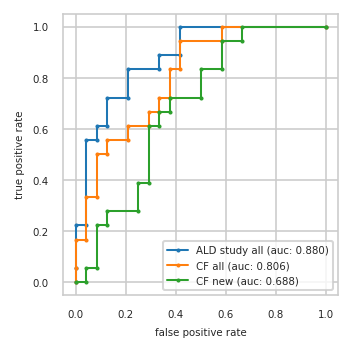

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       CF all       CF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.042 0.000
2          0.000 0.222  0.000 0.167  0.042 0.056
3          0.042 0.222  0.042 0.167  0.083 0.056
4          0.042 0.556  0.042 0.333  0.083 0.222
5          0.083 0.556  0.083 0.333  0.125 0.222
6          0.083 0.611  0.083 0.500  0.125 0.278
7          0.125 0.611  0.125 0.500  0.250 0.278
8          0.125 0.722  0.125 0.556  0.250 0.389
9          0.208 0.722  0.208 0.556  0.292 0.389
10         0.208 0.833  0.208 0.611  0.292 0.611
11         0.333 0.833  0.292 0.611  0.333 0.611
12         0.333 0.889  0.292 0.667  0.333 0.667
13         0.417 0.889  0.333 0.667  0.375 0.667
14         0.417 1.000  0.333 0.722  0.375 0.722
15         1.000 1.000  0.375 0.722  0.500 0.722
16           NaN   NaN  0.375 0.833  0.500 0.833
17           NaN   NaN  0.417 0.833  0.583 0.833
18           NaN   NaN  0.417 0.944  0.583 0.944
19           NaN   NaN  0.583 0.944  0.667 0.944
20           NaN   NaN  0.583 1.000  0.667 1.000
21           NaN   NaN  1.000 1.000  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,CF all,CF new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,P00740;P00740-2,F8WAD8;Q9P0K1;Q9P0K1-2;Q9P0K1-3;Q9P0K1-4;Q9P0K1-5,A0A0G2JLL6;A0A1B0GTE9;A0A1B0GTP1;Q7Z6L0;Q7Z6L0...
2,Q9NR34,P02766,A0A0G2JLV7;A0A0G2JM94;A0A0G2JMI0;A0A0G2JNK8;A0...
3,Q13231;Q13231-3,P08670,A0A075B7B8
4,P04075,P61981,P51688
5,C9JF17;P05090,Q9Y2T3;Q9Y2T3-3,P31321
6,None,P25189;P25189-2,Q96GD0
7,None,P04075,None
8,None,Q14894,None


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf


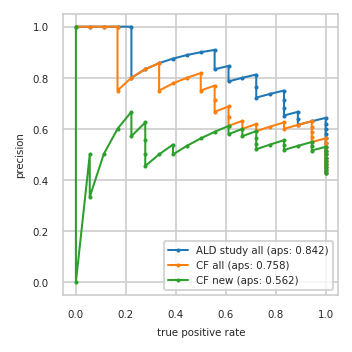

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          CF all          CF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.514 1.000     0.514 1.000     0.514 1.000
8          0.529 1.000     0.529 1.000     0.529 1.000
9          0.545 1.000     0.545 1.000     0.515 0.944
10         0.562 1.000     0.562 1.000     0.531 0.944
11         0.581 1.000     0.548 0.944     0.548 0.944
12         0.600 1.000     0.567 0.944     0.533 0.889
13         0.621 1.000     0.586 0.944     0.517 0.833
14         0.643 1.000     0.607 0.944     0.536 0.833
15         0.630 0.944     0.630 0.944     0.556 0.833
16         0.615 0.889     0.615 0.889     0.538 0.778
17         0.640 0.889     0.600 0.833     0.520 0.722
18         0.667 0.889     0.625 0.833     0.542 0.722
19         0.652 0.833     0.609 0.778     0.565 0.722
20         0.682 0.833     0.591 0.722     0.591 0.722
21         0.714 0.833     0.619 0.722     0.571 0.667
22         0.750 0.833     0.600 0.667     0.600 0.667
23         0.737 0.778     0.632 0.667     0.579 0.611
24         0.722 0.722     0.611 0.611     0.611 0.611
25         0.765 0.722     0.647 0.611     0.588 0.556
26         0.812 0.722     0.688 0.611     0.562 0.500
27         0.800 0.667     0.667 0.556     0.533 0.444
28         0.786 0.611     0.714 0.556     0.500 0.389
29         0.846 0.611     0.769 0.556     0.538 0.389
30         0.833 0.556     0.750 0.500     0.500 0.333
31         0.909 0.556     0.818 0.500     0.455 0.278
32         0.900 0.500     0.800 0.444     0.500 0.278
33         0.889 0.444     0.778 0.389     0.556 0.278
34         0.875 0.389     0.750 0.333     0.625 0.278
35         0.857 0.333     0.857 0.333     0.571 0.222
36         0.833 0.278     0.833 0.278     0.667 0.222
37         0.800 0.222     0.800 0.222     0.600 0.167
38         1.000 0.222     0.750 0.167     0.500 0.111
39         1.000 0.167     1.000 0.167     0.333 0.056
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf


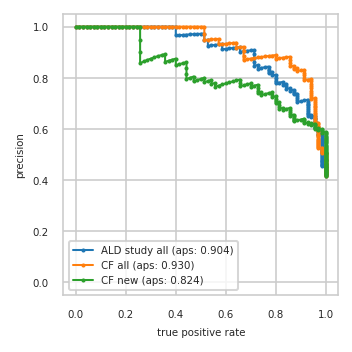

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf


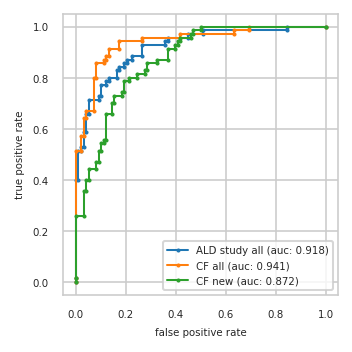

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_CF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF all.pkl'),
 'results_CF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf')}